# Симуляция А/В теста на данных онлайн кинотеатра.

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime
from scipy.stats import norm
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower

# Задача: 

Предполагаетя внедрить новую модель рекомендаций для пользователей сервиса онлайн кинотеатра, которая будет воздействовать на всех пользователей (те кто смотрит и те кто не смотрит контент). Задача сделать дизайн А/В теста и провести сам тест. Результат теста должен показать, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых активных пользователей.

## Дизайн А/В теста

### Анализ данных

Загрузка данных

In [6]:
interactions = pd.read_csv('interactions.csv')
interactions.head()

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [7]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


In [8]:
interactions.shape

(5476251, 5)

Проверяем наличие пропущенных значений

In [9]:
interactions.isnull().sum(axis=0)

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

Для всех пользователей total_duration < 500 (несмотрящие пользователи) принимаем total_duration = 0

In [10]:
interactions.loc[interactions['total_dur'] < 500, 'total_dur'] = 0

### Выбор метрики и анализ распределения

Выберем в качестве исследуемой метрики суммарную продолжительность просмотра определенного контента пользователем (в секундах). Для всех пользователей данные зафиксированы.

Посмотрим распределенние данных.

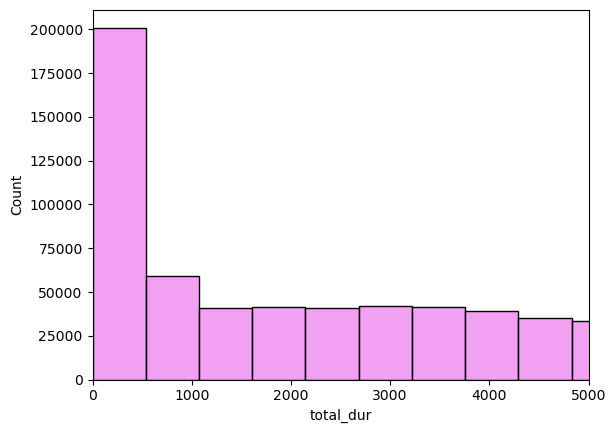

In [11]:
fig, ax = plt.subplots()
ax.set_xlim(0, 5000)
sns.histplot(data=interactions, x=interactions.groupby('user_id')['total_dur'].mean(), bins=10000, color='violet');

total_dur сильно перекошена, есть много нулей и длинный хвост → стоит логарифмировать.

### Выбор стат.критерия

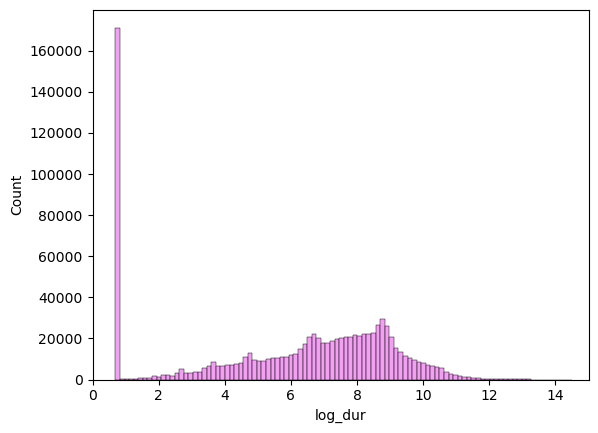

In [12]:
lg_int = interactions.copy()
lg_int['log_dur'] = np.log1p(lg_int['total_dur']+1)

fig, ax = plt.subplots()
ax.set_xlim(0, 15)
sns.histplot(data=lg_int, x=lg_int.groupby('user_id')['log_dur'].mean(), bins=100, color='violet');

Если мы работаем с логафимированными данными, то распредление становиться блже к нормальному, относительно симметричным. Будем использовать  ttest. 

### Анализ надежности и чувствительности

Дополнительные функции:

In [13]:
def salt_generator(salt=None):
    """
    Генерирует случайную строку (соль) для использования при хешировании user_id
    при разделении пользователей на группы в A/B-тестах.
    """
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    """
    Реализует разбивку всей выборки на группы с использованием хеширования user_id
    с использованием соли.
    """
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [30:50<00:00, 18.51s/it]


 power: 100.0% , correctness: 98.0%


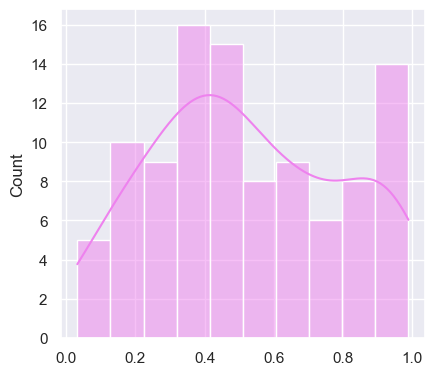

In [9]:
correctness = []  # Оценка устойчивости метрики
power = []        # Оценка чувствительности метрики

for i in tqdm(range(100)):

    new_group = groups_splitter(interactions.copy(), user_salt=salt_generator())

    new_df = pd.merge(interactions, new_group, how="left", on='user_id')

    user_agg = new_df.groupby(['user_id', 'group'])['total_dur'].sum().reset_index()

    vec_a = user_agg[user_agg['group'] == 'A']['total_dur']
    vec_b = user_agg[user_agg['group'] == 'B']['total_dur']

    # Создаём эффект
    vec_b_effect = vec_b * 1.05

    # Логарифмирование
    vec_a_ln = np.log(vec_a + 1)
    vec_b_ln = np.log(vec_b + 1)
    vec_b_effect_ln = np.log(vec_b_effect + 1)

    p_cor = stats.ttest_ind(vec_a_ln, vec_b_ln)[1]
    p_power = stats.ttest_ind(vec_a_ln, vec_b_effect_ln)[1]

    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
power = np.array(power)

sns.set(rc={'figure.figsize': (4.7, 4.27)})
sns.histplot(data=correctness, bins=10, color='violet', kde=True)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100:.1f}% , '
      f'correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100:.1f}%')

Оценка чувствительности метрики (Power Test):
Мы смоделировали эксперимент в группе B (только для проверки).
Затем мы многократно (100 итераций) проводили т-тест, чтобы оценить, насколько часто такой эффект фиксируется как статистически значимый при p-value < 0.05.
Результат: Power ≈ 100% — означает, что метрика чувствительна к эффекту такого масштаба, и при его наличии тест с большой вероятностью его зафиксирует.

Оценка устойчивости метрики (Correctness):
Мы сгенерировали случайные разбиения пользователей на группы A и B без наложения эффекта. Далее проверяли, как часто на этом "нулевом эффекте" метрика ошибочно показывает значимость.
Результат: Correctness ≈ 98% — значит, что метрика в 98% случаев правильно не фиксирует эффект, когда его нет. Таким образом, ложноположительные срабатывания укладываются в допустимые границы.

Применение логарифмирования:
Для нормализации распределения и снижения влияния выбросов мы применили логарифмирование: log(total_dur + 1). Это улучшает свойства метрики и повышает статистическую стабильность тестов.

### Определение MDE (Minimum Detectable Effect) для выбранной метрики

In [14]:
vec = np.log(interactions['total_dur'] + 1)

std = np.std(vec)

n = len(interactions['user_id'].unique()) // 2  
z_alpha = norm.ppf(1 - 0.05 / 2)   
z_power = norm.ppf(0.8)       

mde = (z_alpha + z_power) * std * np.sqrt(2) / np.sqrt(n)

print(f'MDE: {mde * 100:.2f}%')

MDE: 2.24%


MDE для выбранной метрики (total_dur) после логарифмирования он составил ≈2.24%. Наш тест имеет достаточную чувствительность, чтобы поймать эффект в 2.5%. 

## Симуляция А/В теста

Считаем, что прошло достаточное количество времени. А/В тест завершился. 

Реализуем эффект для группы В отвечающий условию: модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых активных пользователей.

Реализуем разбивку пользователей на две группы:

In [15]:
interactions['hash'] = ((interactions['user_id'].astype(str)) + '#' + 'kiontestmodel20210114').apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

interactions['group'] = ((interactions['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,hash,group
0,176549,9506,2021-05-11,4250,72.0,c0dcfa04ab3507322295d6857d979107cc6061ea3cbf35...,A
1,699317,1659,2021-05-29,8317,100.0,48752761f66154f154137ce0bb85271129bf67f46acd07...,B
2,656683,7107,2021-05-09,0,0.0,7d15f254741e754652eb744076bc189601319ac48adcd3...,A
3,864613,7638,2021-07-05,14483,100.0,4827bc72eec24e0711f3bbdee5a40a6b1e13170d99a8db...,A
4,964868,9506,2021-04-30,6725,100.0,e5fea174d818b7a2540615858c8e510bee788600bc4b74...,A


для удобства удаляем столбец 'hash'

In [16]:
interactions.drop(columns = 'hash', inplace = True)

Проверяем как реализовалась разбивка на группы

In [17]:
interactions.groupby(['group']).count()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
group,,,,,
A,2735978,2735978,2735978,2735978,2735559
B,2740273,2740273,2740273,2740273,2739864


Теперь надо наложить эфект на одну из групп.

In [18]:
user_agg = (
    interactions[interactions['group'] == 'B']
    .groupby('user_id')['total_dur']
    .sum()
    .reset_index()
)

threshold = user_agg['total_dur'].quantile(0.9)

user_agg['is_top10'] = user_agg['total_dur'] >= threshold

user_agg['adjusted_total_dur'] = user_agg.apply(
    lambda row: row['total_dur'] * 1.025 if row['is_top10'] else row['total_dur'],
    axis=1
)

### Проверка гипотезы:

Нулевая гипотеза (H₀): между группами A и B нет статистически значимой разницы в метрике.

Альтернативная гипотеза (H₁): между группами есть разница.

Перед запуском мы проверили устойчивость и чувствительность выбранной метрики. total_dur показала сильную скошенность, поэтому была логарифмирована. Мы рассчитали MDE = 2.24%, что укладывается в наш ожидаемый эффект 2.5%. На 100 симуляциях с рандомизацией пользователей достигнута чувствительность (power) 100% при ошибке 1-го рода ~2%. Таким образом, метрика позволяет зафиксировать нужный эффект с высокой вероятностью.

In [19]:
stats.ttest_ind
vec_a = interactions[interactions['group'] == 'A']['total_dur']
vec_b = user_agg['adjusted_total_dur']

vec_a_ln = np.log(vec_a + 1)
vec_b_effect_ln = np.log(vec_b + 1)

p = stats.ttest_ind(vec_a_ln, vec_b_effect_ln)[1]

print(f'p-value: {p:.2f}')

p-value: 0.00


p-value < 0.05 отвергаем нулевую гипотезу. Между исследуемыми группами А и В есть разница. 

Полученному результату можно доверять, так как MDE составляет 2.5%, наш стат критерий чувствителен к таким изменениям и в 97% не происходит ложное срабатывание. 

## Итоги A/B теста

В данном проекте была проведена симуляция A/B теста для оценки эффективности новой модели рекомендаций в онлайн-кинотеатре. 

### Цель:

Проверить, влияет ли новая модель рекомендаций на ключевую пользовательскую метрику время просмотра total_dur.

### Проведённые этапы:

- Разработан **дизайн эксперимента**: сформулирована гипотеза, выбрана метрика, определены контрольная и тестовая группы.
- Произведён **расчёт мощности теста (power analysis)** с использованием `t-test`. Power ≈ 100% — означает, что метрика чувствительна к эффекту такого масштаба, и при его наличии тест с большой вероятностью его зафиксирует. Correctness ≈ 98% — значит, что метрика в 98% случаев правильно не фиксирует эффект, когда его нет. Таким образом, ложноположительные срабатывания укладываются в допустимые границы.
- Расчитано MDE (Minimum Detectable Effect) для выбранной метрики. MDE = 2.24 %. 
- Проведено **A/B сравнение** на синтетических данных.
- Использованы статистические критерии:
  - **t-тест** для проверки различий средних
- Интерпретированы значения `p-value` и проверена значимость различий между группами. Различая между группами были сгенерированны в соответствии с условиями задачи: в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых активных пользователей. 


### Выводы:

- **Результаты теста** показали, что в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых активных пользователей.
- При уровне значимости α = 0.05 и мощности теста 100 %, текущие данные позволяют сделать уверенные выводы о наличие эффекта после обновлений в онлайн кинотеатре, так как модель А/В теста позволяет зафиксировать эффект превышающий 2.24 %.
